# Solutions to Exercise 1

[<img src="https://img.shields.io/badge/Documentation-Main_Page-orange.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/)
[<img src="https://img.shields.io/badge/I_Need_Help-Installation-teal.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/installation.html)
[<img src="https://img.shields.io/badge/I_Need_Help-How_To_Run-green.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/running.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Quick_Guide-blue.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Reference-purple.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_ref.html)
[<img src="https://img.shields.io/badge/I_Need_Help-JSON_Output-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/program_json.html)

The code cells below show how to set up energy calculations on the water molecule, and how to run the calculations from within the notebook.

In [1]:
import os
import sys
import json
import time
import shutil
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

ROOT = os.path.dirname(os.path.abspath(''))
SOLUTIONS = os.path.join(ROOT, 'solutions')
sys.path.append(ROOT)

from utils.functions import MRChemOutput

## Define some useful functions

In [2]:
def readCoords(f):
    """Read XYZ file and return as MRChem JSON friendly string."""
    with open(f) as file:
        return '\n'.join([line.strip() for line in file.readlines()[2:]])

def makeInput(world_prec=None, xyzfile=None, fname=None):
    """Write MRChem JSON input file."""
    i = {
        'world_prec': world_prec,
        'world_unit': 'angstrom',
        'Molecule': {
            'charge': 0,
            'multiplicity': 1,
            'translate': True,
            'coords': readCoords(xyzfile)
        },
        'WaveFunction': {
            'method': 'pbe', 
            'restricted': True
        },
        'SCF': {
            'guess_type': 'sad_dz',
            'guess_prec': 1e-4,
            'kain': 5,
            'write_orbitals': True,
            'localize': True,
            'max_iter': 20
        }
    }
    
    with open(fname+'.inp', 'w') as f:
        json.dump(i, f, indent=2)

def submit(nprocs=None, dest=None, inputfile=None):
    """Make calc dir, copy move inputfile, and start the calculation."""
    # Check if all arguments given
    assert not any([nprocs is None, dest is None, inputfile is None]), 'Missing arguments'
    
    # Make calc dir
    if os.path.exists(dest):
        shutil.rmtree(dest)
    os.makedirs(dest)
        
    # Check if input file exists
    if not os.path.exists(inputfile):
        print(f'Error: Input file <{inputfile}> not found')
        return
    
    shutil.move(inputfile, os.path.join(dest, inputfile))
    os.chdir(dest)
    os.environ['OMP_NUM_THREADS'] = str(nprocs)
    subprocess.call(['mrchem', '--json',  inputfile])
    os.chdir(SOLUTIONS)

## Loop over the precisions and run calculations

**ProTip**: You could save some time by reusing the MW3 orbitals as starting guess for the higher precision jobs. How to do this is explained in the documentation:

[<img src="https://img.shields.io/badge/I_Need_Help-MW_Initial_Guess-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html#write-orbitals)

In [3]:
# Uncomment the makeInput and submit commands
# and delete the time.sleep command to run the calculations
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

mw_results = {}
for i, (label, prec) in enumerate(precisions.items()):
    print(label.upper())
    jobname = f'water_{label}'
    dest = os.path.join(SOLUTIONS, jobname+'_calc')
    xyzfile = '../geometries/water.xyz'

    t0 = time.time()
    # makeInput(world_prec=prec, xyzfile=xyzfile, fname=jobname)
    # submit(nprocs=6, dest=dest, inputfile=jobname+'.inp')
    time.sleep((i+1)**2)
    t1 = time.time()
        
    print(f'   >>> Finished after {t1-t0:.1f} seconds')

MW3
   >>> Finished after 1.0 seconds
MW4
   >>> Finished after 4.0 seconds
MW5
   >>> Finished after 9.0 seconds


## Plot the SCF convergence for each job and store the energies

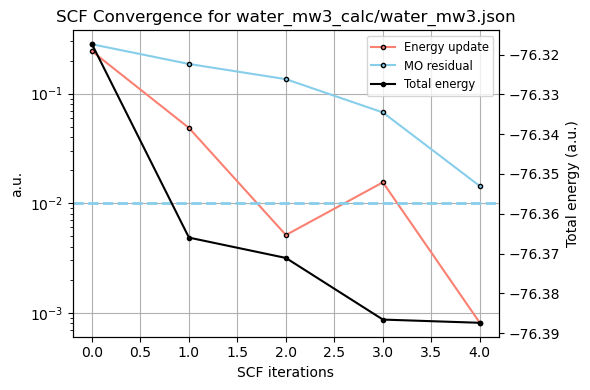

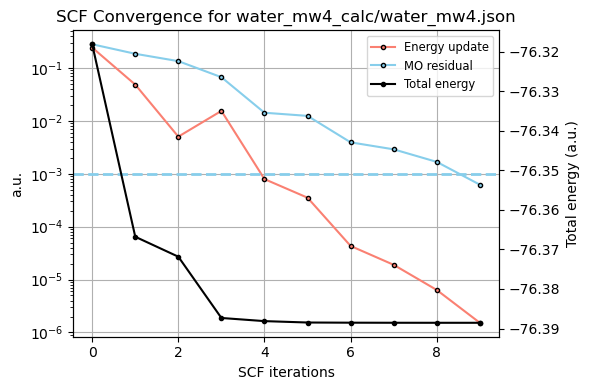

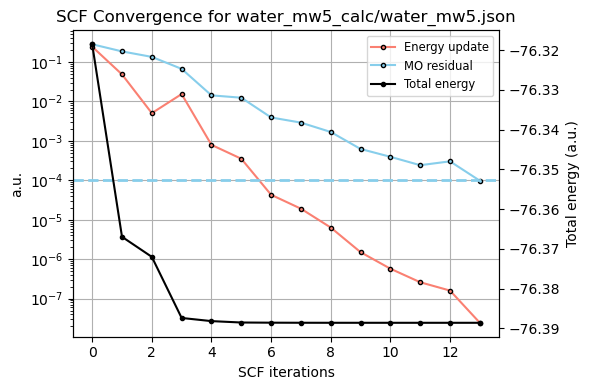

In [4]:
base = 'water'
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

mw_data = []
for label, prec in precisions.items():
    f = os.path.join(f'{base}_{label}_calc', f'{base}_{label}.json')
    calc = MRChemOutput(f)
    mw_data.append((label, calc.getFinalSCFEnergy()))
    calc.plotSCFConvergence()

## Compare to GTOs

<BarContainer object of 6 artists>

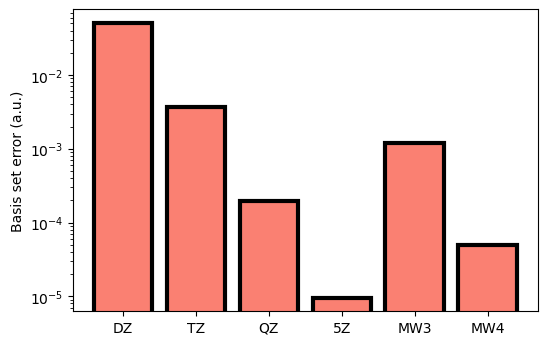

In [5]:
# Make DataFrame
gto_data = [
    ('dz', -76.337833062097),
    ('tz', -76.384930572433),
    ('qz', -76.388407845518),
    ('5z', -76.388593505849)
]

df = pd.DataFrame(gto_data+mw_data, columns=['Basis', 'Energy'])
ref = df.loc[df.Basis == 'mw5']['Energy'].values[0]
df['Error'] = df['Energy'] - ref
df.drop(df.loc[df.Basis == 'mw5'].index, inplace=True)

# Plot
fig, ax = plt.subplots(dpi=100)
ax.set_yscale('log')
ax.set_ylabel('Basis set error (a.u.)')

ax.bar(df.Basis.str.upper(), df.Error, edgecolor='black', color='salmon', lw=3)